# Info

https://www.kaggle.com/datasets/ahmedabelal/arabic-poetry

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import kagglehub

In [4]:
import os
import re
import json
import random

In [5]:
import tqdm
import pickle

In [6]:
!pip install arabic-reshaper python-bidi
import arabic_reshaper
from bidi.algorithm import get_display

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras.utils import Sequence

2025-10-19 13:31:35.023903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760880695.445154      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760880695.584707      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Functions

In [9]:
def count_n_lines(text):
    return len(text.split('\n'))

In [10]:
def count_n_words(text):
    return len(text.split(' '))

In [11]:
def count_n_chars(text):
    return len(text)

In [12]:
def read_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()

    json_data = json.loads(data)
    return json_data


def write_json(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

In [13]:
def read_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def write_pickle(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

# Constants

In [14]:
WINDOW_SIZE = 100

In [15]:
START_TOKEN = '#'

In [16]:
# BASE_DIR = 'drive/MyDrive/BBB'
BASE_DIR = ''

UTILS_DIR = os.path.join(BASE_DIR, 'utils')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')

os.makedirs(UTILS_DIR, exist_ok=True)
os.makedirs(TRAIN_DIR, exist_ok=True)

TOKENIZER_PATH = os.path.join(UTILS_DIR, 'tokenizer.json')

In [17]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [18]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [19]:
EPOCHS = 20
BATCH_SIZE = 1024

# Data Loading

In [20]:
# Download latest version
path = kagglehub.dataset_download("ahmedabelal/arabic-poetry")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arabic-poetry


In [21]:
os.listdir(path), path

(['Arabic_poetry_dataset.csv'], '/kaggle/input/arabic-poetry')

In [22]:

df = pd.read_csv(os.path.join(path, os.listdir(path)[0] ))

# Dataset Exploration

In [23]:
pd.concat([df.head(), df.sample(5), df.tail()])

id        category           poet_name  \
0          0        ÿßŸÑÿ•ŸÖÿßÿ±ÿßÿ™       ÿÆŸÑŸÅÿßŸÜ ÿ®ŸÜ ŸÖÿµÿ®ÿ≠   
1          1        ÿßŸÑÿ•ŸÖÿßÿ±ÿßÿ™       ÿÆŸÑŸÅÿßŸÜ ÿ®ŸÜ ŸÖÿµÿ®ÿ≠   
2          2        ÿßŸÑÿ•ŸÖÿßÿ±ÿßÿ™       ÿÆŸÑŸÅÿßŸÜ ÿ®ŸÜ ŸÖÿµÿ®ÿ≠   
3          3        ÿßŸÑÿ•ŸÖÿßÿ±ÿßÿ™       ÿÆŸÑŸÅÿßŸÜ ÿ®ŸÜ ŸÖÿµÿ®ÿ≠   
4          4        ÿßŸÑÿ•ŸÖÿßÿ±ÿßÿ™       ÿÆŸÑŸÅÿßŸÜ ÿ®ŸÜ ŸÖÿµÿ®ÿ≠   
16765  16939   ÿßŸÑÿπÿµÿ± ÿßŸÑÿπÿ®ÿßÿ≥Ÿä   ÿ£ÿ®Ÿà ÿßŸÑÿπŸÑÿßÿ° ÿßŸÑŸÖÿπÿ±Ÿä   
11400  11574             ŸÖÿµÿ±  ŸÖÿµÿ∑ŸÅŸâ ÿµÿßÿØŸÇ ÿßŸÑÿ±ÿßŸÅÿπŸä   
37613  37787   ÿπÿµÿ± ÿßŸÑŸÖÿÆÿ∂ÿ±ŸÖŸàŸÜ     ÿπŸÑŸä ÿ®ŸÜ ÿ£ÿ®Ÿä ÿ∑ÿßŸÑÿ®   
13700  13874   ÿßŸÑÿπÿµÿ± ÿßŸÑÿ¨ÿßŸáŸÑŸä             ÿßŸÑÿÆŸÜÿ≥ÿßÿ°   
3272    3379           ÿßŸÑŸäŸÖŸÜ       ŸÖÿ≠ŸÖÿØ ÿßŸÑÿ¥ŸàŸÉÿßŸÜŸä   
54939  55113  ÿßŸÑÿπÿµÿ± ÿßŸÑŸÖŸÖŸÑŸàŸÉŸä            ÿßÿ®ŸÜ ÿ≤ŸÖÿ±ŸÉ   
54940  55114  ÿßŸÑÿπÿµÿ± ÿßŸÑŸÖŸÖŸÑŸàŸÉŸä            ÿßÿ®ŸÜ ÿ≤ŸÖÿ±ŸÉ   
54941  55115  ÿßŸÑÿπÿµÿ± ÿßŸÑŸÖŸÖŸÑŸàŸÉŸä            ÿßÿ®ŸÜ ÿ≤ŸÖÿ±ŸÉ   
54942  55116  ÿßŸÑÿπÿµÿ± ÿßŸÑŸÖŸÖŸÑŸàŸÉŸä            ÿßÿ®ŸÜ ÿ≤ŸÖÿ±ŸÉ   
54943  55117  ÿßŸÑÿπÿµÿ± ÿßŸÑŸÖŸÖŸÑŸàŸÉŸä            ÿßÿ®ŸÜ ÿ≤ŸÖÿ±ŸÉ   

                         poem_title  \
0         ÿ®ÿØÿ™ ÿ™ÿÆÿ™ÿßŸÑ ŸÅŸä ÿ≠ŸèŸÑŸÑ ÿßŸÑÿ¨ŸÖÿßŸÑŸê   
1              Ÿäÿß ÿ∑ÿßÿ¶ÿ± ÿßŸÑÿ¥ÿπÿ± ÿßŸÑŸÇÿ±Ÿäÿ±   
2              ÿ®ŸÜÿ™ ÿ≠ÿ¨ÿ±ÿßÿ™ ÿ£ÿ±Ÿâ ŸÖŸÜ ÿπÿ¨ÿ®   
3      Ÿáÿ∞ÿß ÿßŸÑÿ±ÿ®Ÿäÿπ ÿ®ŸÜŸàÿ± ÿßŸÑÿ≠ÿ≥ŸÜ ŸàÿßŸÅÿßŸÜÿß   
4       ÿ±Ÿàÿ≠Ÿä ŸÅÿØÿßŸÉ Ÿàÿ•ŸÜ ŸÖŸèŸÜÿ≠ÿ™Ÿè ÿµÿØŸàÿØÿßŸã   
16765   ÿ≥ŸÉŸÜÿ™ ÿ•ŸÑŸâ ÿßŸÑÿØŸÜŸäÿß ŸÅŸÑŸÖÿß ÿπÿ±ŸÅÿ™Ÿáÿß   
11400        ÿ¢ŸÅÿ© ÿßŸÑÿπÿßŸÑŸÖ ÿ£ŸÜ ŸÑÿß ŸäÿπŸÖŸÑÿß   
37613    ÿ£ÿ®Ÿâ ÿßŸÑŸÑŸá ÿ•ŸÑÿß ÿ£ŸÜ ÿµŸÅŸäŸÜ ÿØÿßÿ±ŸÜÿß   
13700           Ÿäÿß ÿπŸäŸÜ ÿ¨ŸàÿØŸä ÿ®ÿßŸÑÿØŸÖŸàÿπ   
3272        ŸÉÿ£ŸÜ Ÿàÿ¨Ÿá ÿßŸÑŸÜŸáÿ± ÿ•ÿ∞ ÿ≠ŸÅÿ™ ÿ®Ÿá   
54939             ÿßÿ≥ŸÇŸÜŸä ÿ®ŸÜÿ™ ÿßŸÑÿØŸàÿßŸÑŸä   
54940             ÿßŸÑÿ•ŸÑÿßŸá Ÿäÿ≠ŸÖÿØ ŸàŸäÿ¥ŸÉÿ±   
54941            ÿ£ŸÑŸÜŸä ÿ£ÿ®ŸÑÿ∫ ŸÖŸÜ ÿßŸÑÿπŸÖŸÑ   
54942     ŸÖŸáÿ±ÿ¨ÿßŸÜ ŸáŸàÿ∞ÿß ÿßŸÑŸäŸàŸÖ ŸÑŸÑÿ•ŸÜÿ≥ÿßŸÜ   
54943            ÿßŸÑÿ£ŸÖŸäÿ± ÿ®ÿØÿ± ÿßŸÑŸÖŸàÿßŸÉÿ®   

                                               poem_text  
0      ÿ®ÿØÿ™ ÿ™ÿÆÿ™ÿßŸÑ ŸÅŸä ÿ≠ŸèŸÑŸÑ ÿßŸÑÿ¨ŸÖÿßŸÑŸê\nŸàÿ¨ÿßÿØÿ™ ÿ®ÿßŸÑÿ≤Ÿäÿßÿ±ÿ© ŸàÿßŸÑŸà...  
1      Ÿäÿß ÿ∑ÿßÿ¶ÿ± ÿßŸÑÿ¥ÿπÿ± ÿßŸÑŸÇÿ±Ÿäÿ±\nŸäÿß Ÿàÿ≠Ÿä ÿ•ŸÑŸáÿßŸÖ ÿßŸÑÿµÿØŸàÿ±\nÿ£ÿ≥ÿπ...  
2      ÿ®ŸÜÿ™ ÿ≠ÿ¨ÿ±ÿßÿ™ ÿ£ÿ±Ÿâ ŸÖŸÜ ÿπÿ¨ÿ®\nÿ£ŸÜ ÿ£ÿ±Ÿâ ŸÅŸäŸÉ ÿ¨ŸÖÿßŸÑ ÿßŸÑÿπÿ±ÿ®\nÿØ...  
3      Ÿáÿ∞ÿß ÿßŸÑÿ±ÿ®Ÿäÿπ ÿ®ŸÜŸàÿ± ÿßŸÑÿ≠ÿ≥ŸÜ ŸàÿßŸÅÿßŸÜÿß\nŸàŸÇÿØ ŸÉÿ≥ÿß ÿßŸÑÿ£ÿ±ÿ∂ ÿ®ÿß...  
4      ÿ±Ÿàÿ≠Ÿä ŸÅÿØÿßŸÉ Ÿàÿ•ŸÜ ŸÖŸèŸÜÿ≠ÿ™Ÿè ÿµÿØŸàÿØÿßŸã\nÿ£ÿÆŸÅÿßŸÉ ŸÖÿß ÿ®Ÿä ÿ£ŸÖ ÿ£ÿ∑...  
16765  ÿ≥ŸéŸÉŸéŸÜÿ™Ÿè ÿ•ŸêŸÑŸâ ÿßŸÑÿØŸèŸÜŸäÿß ŸÅŸéŸÑŸéŸÖŸëÿß ÿπŸéÿ±ŸéŸÅÿ™ŸèŸáÿß\nÿ™ŸéŸÖŸéŸÜŸë...  
11400  ÿ¢ŸÅÿ©Ÿè ÿßŸÑÿπÿßŸÑŸÖŸê ÿ£ŸÜ ŸÑÿß ŸäÿπŸÖŸÑÿß\nŸàÿ¥ŸÇÿß ÿßŸÑÿ¨ÿßŸáŸÑŸê ÿ£ŸÜ ŸÑÿß Ÿä...  
37613  ÿ£Ÿéÿ®Ÿâ ÿßŸÑŸÑŸéŸáŸè ÿ•ŸêŸÑŸëÿß ÿ£ŸéŸÜŸëŸé ÿµŸêŸÅŸëŸêŸäŸÜŸé ÿØÿßÿ±ŸèŸÜÿß\nŸàŸéÿØÿßÿ±...  
13700  Ÿäÿß ÿπŸéŸäŸÜŸê ÿ¨ŸàÿØŸä ÿ®ŸêÿßŸÑÿØŸèŸÖŸàÿπŸê \nÿßŸÑŸÖŸèÿ≥ÿ™ŸéŸáŸêŸÑŸëÿßÿ™Ÿê ÿßŸÑÿ≥Ÿé...  
3272   ŸÉŸéÿ£ŸéŸÜŸëŸé ŸàŸéÿ¨ŸíŸáŸé ÿßŸÑŸÜŸëŸéŸáŸíÿ±Ÿê ÿ•ÿ∞Ÿí ÿ≠ŸéŸÅŸëŸéÿ™Ÿí ÿ®ŸêŸáŸê\nÿ£Ÿéÿ¥...  
54939  ÿßÿ≥ŸÇŸÜŸä ÿ®ŸÜÿ™ ÿßŸÑÿØŸàÿßŸÑŸä\nÿ•ŸÜŸáÿß ŸÜÿπŸÖ ÿßŸÑÿØŸàÿßŸÑŸä\nÿ≥ŸÇŸëŸÜŸä ÿ≥ÿ± ...  
54940  ÿßŸÑÿ•ŸÑÿßŸá Ÿäÿ≠ŸÖÿØ ŸàŸäÿ¥ŸÉÿ±\nÿßŸÑŸÖÿ∑ÿ± ŸÖŸÜ ÿßŸáŸÜ ŸÑÿ¥ŸÉÿ±\nŸàÿßŸÑÿ•ŸÑÿßŸá ...  
54941  ÿ£ŸÑŸÜŸäŸë ÿ£ÿ®ŸÑÿ∫ ŸÖŸÜ ÿßŸÑÿπŸÖŸÑ\nÿßŸÑŸÑŸëŸá Ÿäÿ®ŸÑŸëÿ∫ŸÉ ÿßŸÑÿ£ŸÖŸÑ\nŸÜÿ≤ŸäŸá ...  
54942  ŸÖŸáÿ±ÿ¨ÿßŸÜ ŸáŸàÿ∞ÿß ÿßŸÑŸäŸàŸÖ ŸÑŸÑÿ•ŸÜÿ≥ÿßŸÜ\nÿ£ŸÑŸÜÿ≤ŸëŸäŸá ŸàÿßŸÑÿ≠ÿ≥ŸÜ ŸàÿßŸÑÿ•...  
54943  ÿßŸÑÿ£ŸÖŸäÿ± ÿ®ÿØÿ± ÿßŸÑŸÖŸàÿßŸÉÿ®\nÿ≤ÿØŸÑ ŸÜÿßÿ¨ŸÖ ŸÅÿßŸÑŸÉŸàÿßŸÉÿ®\nÿßŸÑÿ≥ÿπŸàÿØ ...

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54944 entries, 0 to 54943
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54944 non-null  int64 
 1   category    54944 non-null  object
 2   poet_name   54944 non-null  object
 3   poem_title  54944 non-null  object
 4   poem_text   54944 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [25]:
df.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


id       category         poet_name  \
count   54944.000000          54944             54944   
unique           NaN             28               538   
top              NaN  ÿßŸÑÿπÿµÿ± ÿßŸÑÿπÿ®ÿßÿ≥Ÿä  ÿßÿ®ŸÜ ŸÜÿ®ÿßÿ™Ÿá ÿßŸÑŸÖÿµÿ±Ÿä   
freq             NaN          10116              1726   
mean    27636.214673            NaN               NaN   
std     15875.618346            NaN               NaN   
min         0.000000            NaN               NaN   
25%     13909.750000            NaN               NaN   
50%     27645.500000            NaN               NaN   
75%     41381.250000            NaN               NaN   
max     55117.000000            NaN               NaN   

                     poem_title  \
count                     54944   
unique                    54300   
top     ŸÑÿπŸÖÿ±Ÿä ŸàŸÖÿß ÿπŸÖÿ±Ÿä ÿπŸÑŸä ÿ®ŸáŸäŸÜ   
freq                          4   
mean                        NaN   
std                         NaN   
min                         NaN   
25%                         NaN   
50%                         NaN   
75%                         NaN   
max                         NaN   

                                                poem_text  
count                                               54944  
unique                                              54767  
top     ÿ∏ŸéŸÑŸëŸéÿ™ ÿ®ŸêŸÇŸèŸÖŸëŸé ŸÖŸéÿ∑ŸêŸäŸëŸéÿ™Ÿä ŸäŸéÿπÿ™ÿßÿØŸèŸáÿß\nŸáŸéŸÖŸëÿßŸÜŸê ÿ∫Ÿè...  
freq                                                    2  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

# Data Preprocessing

In [26]:
import re

def clean_poem_text(txt):
    # Normalize Arabic forms to standard letters
    arabic_normalization = {
        "ÿ£": "ÿß", "ÿ•": "ÿß", "ÿ¢": "ÿß",
        "ÿ§": "Ÿà", "ÿ¶": "Ÿä", "Ÿâ": "Ÿä",
        "ÿ©": "Ÿá", "€Ä": "Ÿá",
        "⁄Ø": "ŸÉ", "Ÿæ": "ÿ®", "⁄Ü": "ÿ¨",
        "⁄ò": "ÿ≤",
        "€å": "Ÿä",   # Persian Yeh ‚Üí Arabic Yeh
    }

    for k, v in arabic_normalization.items():
        txt = txt.replace(k, v)

    # Remove Tatweel (ŸÄ)
    txt = txt.replace("ŸÄ", "")

    # Remove diacritics (tashkeel)
    txt = re.sub(r'[\u064B-\u0652]', '', txt)

    # Remove English letters and digits
    txt = re.sub(r'[A-Za-z0-9]', '', txt)

    # Remove non-Arabic punctuation except (ÿå ÿõ ÿü)
    txt = re.sub(r'[^\u0600-\u06FF\nÿåÿõÿü ]', '', txt)

    # Remove tabs
    txt = re.sub(r'\t', ' ', txt)

    # Remove repeated spaces but keep newlines
    txt = re.sub(r' {2,}', ' ', txt)

    # Remove extra newlines
    txt = re.sub(r'\n{2,}', '\n', txt)

    # Trim each line
    txt = '\n'.join(line.strip() for line in txt.split('\n'))

    return txt.strip()

In [27]:
df['poem_text'] = df['poem_text'].apply(clean_poem_text)

In [28]:
df['category'] = df['category'].apply(clean_poem_text)

# Data Analysis

In [29]:
df['poem_n_lines'] = df['poem_text'].apply(count_n_lines)

In [30]:
df['poem_n_chars'] = df['poem_text'].apply(count_n_chars)

In [31]:
df['poem_n_words'] = df['poem_text'].apply(count_n_words)

# Data Visualization

In [32]:
plt.style.use(plt.style.available[12])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Lines per Poem'}, xlabel='poem_n_lines', ylabel='Count'>

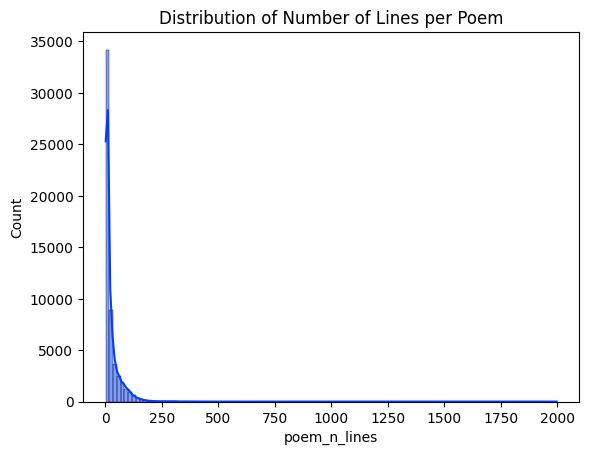

In [33]:
plt.title("Distribution of Number of Lines per Poem")
sns.histplot(data=df, x='poem_n_lines', bins=120, kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Chars per Poem'}, xlabel='poem_n_chars', ylabel='Count'>

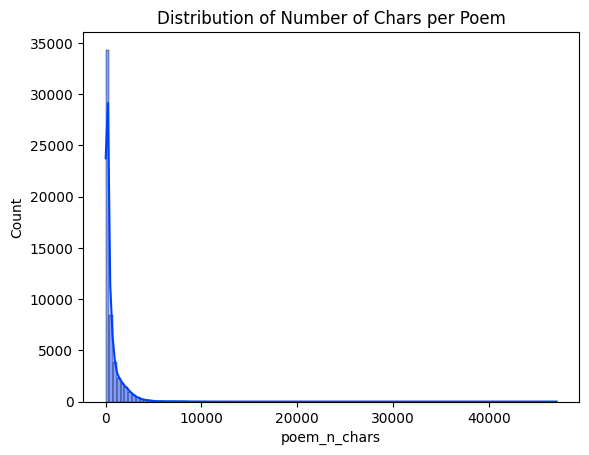

In [34]:
plt.title("Distribution of Number of Chars per Poem")
sns.histplot(data=df, x='poem_n_chars', bins=120, kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Distribution of Number of Words per Poem'}, xlabel='poem_n_words', ylabel='Count'>

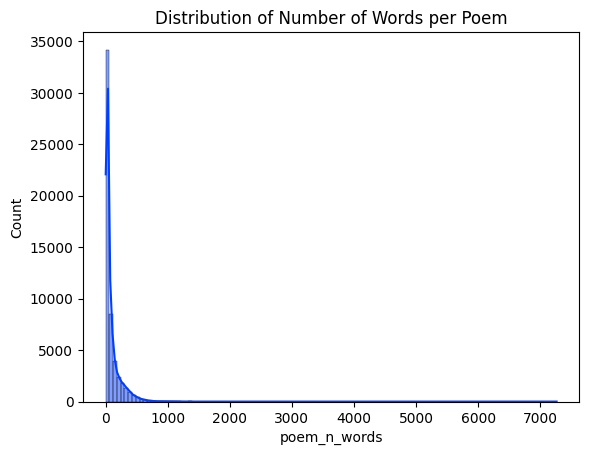

In [35]:
plt.title("Distribution of Number of Words per Poem")
sns.histplot(data=df, x='poem_n_words', bins=120, kde=True)

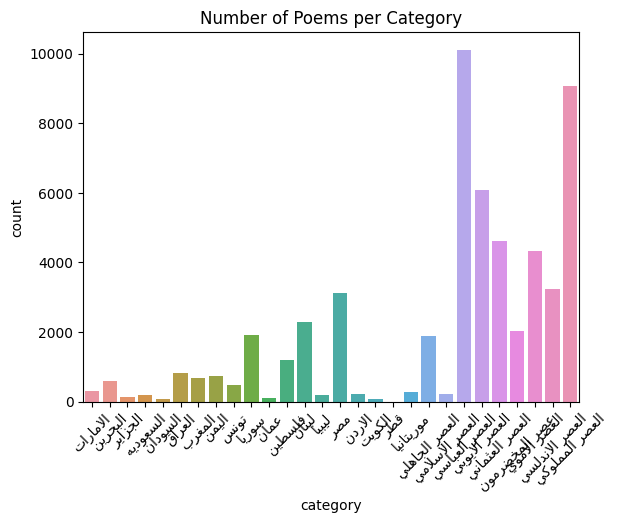

In [36]:
plt.title("Number of Poems per Category")
ax = sns.countplot(data=df, x='category')
plt.xticks(rotation=45)

labels = [t.get_text() for t in ax.get_xticklabels()]
reshaped_labels = [get_display(arabic_reshaper.reshape(l)) for l in labels]
ax.set_xticklabels(reshaped_labels, rotation=45)

plt.show()

# Tokenizer

In [37]:
if os.path.exists(TOKENIZER_PATH):
    tokenizer_dict = read_json(TOKENIZER_PATH)
    print("Loaded existing tokenizer with {} tokens.".format(len(tokenizer_dict)))
else:
    # Create tokenizer
    chars_set = set()

    for seq in tqdm.tqdm(list(df['poem_text'])):
        chars_set.update(list(seq))

    chars_list = sorted(list(chars_set))

    if START_TOKEN in chars_list:
        chars_list.remove(START_TOKEN)

    # to be at index 0
    chars_list.insert(0, START_TOKEN)

    tokenizer_dict = {ch: idx for idx, ch in enumerate(chars_list)}

    write_json(TOKENIZER_PATH, tokenizer_dict)
    print("Created new tokenizer with {} tokens.".format(len(tokenizer_dict)))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54944/54944 [00:01<00:00, 29941.56it/s]

Created new tokenizer with 35 tokens.


In [38]:
def tokenizer_decode(sequence):
  msg = ""

  for idx in sequence:
    msg += list(tokenizer_dict.keys())[list(tokenizer_dict.values()).index(idx)]

  return msg

# Data Scanner

In [39]:
scanned_windows_df = []

In [40]:
for idx, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    poem_id = row['id']
    poem_text = row['poem_text']

    n_chars = len(poem_text)

    start_i = -1 * WINDOW_SIZE + 1

    while True:
        end_i = start_i + WINDOW_SIZE

        if end_i >= n_chars:
            break

        scanned_windows_df.append(
            {
                'poem_id': poem_id,
                'start_i': start_i,
            }
        )

        start_i += 1

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54944/54944 [00:18<00:00, 3049.85it/s]


In [41]:
print("Converting to DataFrame")
scanned_windows_df = pd.DataFrame(scanned_windows_df)

Converting to DataFrame


In [42]:
scanned_windows_df

poem_id  start_i
0               0      -99
1               0      -98
2               0      -97
3               0      -96
4               0      -95
...           ...      ...
33779646    55117     1092
33779647    55117     1093
33779648    55117     1094
33779649    55117     1095
33779650    55117     1096

[33779651 rows x 2 columns]

# Data Split

In [43]:
scanned_windows_train, scanned_windows_df_test = train_test_split(
    scanned_windows_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)

scanned_windows_df_val, scanned_windows_df_test = train_test_split(
    scanned_windows_df_test,
    test_size= TEST_SIZE / (TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_SEED
)

In [44]:
print(f"Scanned Train len:  {len(scanned_windows_train):,}")
print(f"Scanned Val len:    {len(scanned_windows_df_val):,}")
print(f"Scanned Test len:   {len(scanned_windows_df_test):,}")


Scanned Train len:  27,023,720
Scanned Val len:    3,377,965
Scanned Test len:   3,377,966


# Data Loader

In [45]:
# Global cache shared across all DataLoader instances
_GLOBAL_POEM_CACHE = {}


class DataLoader(Sequence):
    def __init__(self, scanned_df, df, tokenizer_dict,
                 batch_size=BATCH_SIZE,
                 shuffle=True,
                 window_size=WINDOW_SIZE,
                 start_token=START_TOKEN,
                 drop_random=0.0):

        global _GLOBAL_POEM_CACHE

        self.scanned_df = scanned_df.reset_index(drop=True)
        self.df = df
        self.tokenizer_dict = tokenizer_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.window_size = window_size
        self.start_token = start_token
        self.drop_random = np.clip(drop_random, 0.0, 0.9)  # prevent full drop

        # Add new poems to the global cache (if not already cached)
        new_poems = df[~df['id'].isin(_GLOBAL_POEM_CACHE)]
        if len(new_poems) > 0:
            for poem_id, poem_text in zip(new_poems['id'].values, new_poems['poem_text'].values):
                _GLOBAL_POEM_CACHE[poem_id] = poem_text
            print(f"[DataLoader] Cached {len(new_poems)} new poems ‚Üí total cache size: {len(_GLOBAL_POEM_CACHE)}")

        self.poem_cache = _GLOBAL_POEM_CACHE
        self.on_epoch_end()

    def __len__(self):
        effective_len = int(len(self.scanned_df) * (1 - self.drop_random))

        return effective_len // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.scanned_df.iloc[batch_indices]

        poem_ids = batch_df['poem_id'].values
        starts = batch_df['start_i'].values

        X, y = self._generate_pairs_fast(poem_ids, starts)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.scanned_df))

        if self.shuffle:
            np.random.shuffle(self.indices)

        # üí° Apply drop_random to reduce samples per epoch
        if self.drop_random > 0:
            keep_n = int(len(self.indices) * (1 - self.drop_random))
            self.indices = self.indices[:keep_n]

    def _generate_pairs_fast(self, poem_ids, starts):
        X, y = [], []
        ws = self.window_size
        tdict = self.tokenizer_dict
        start_token = self.start_token
        poem_cache = self.poem_cache

        for poem_id, start_i in zip(poem_ids, starts):
            poem_text = poem_cache.get(poem_id)
            if poem_text is None:
                continue  # skip missing poem

            n_pad = -start_i if start_i < 0 else 0
            pos_start_id = max(start_i, 0)

            seq = start_token * n_pad + poem_text[pos_start_id:pos_start_id + ws - n_pad]
            if pos_start_id + ws - n_pad >= len(poem_text):
                continue  # skip incomplete window

            label = poem_text[pos_start_id + ws - n_pad]

            X.append([tdict[ch] for ch in seq])
            y.append(tdict[label])

        return np.array(X, dtype=np.int32), np.array(y, dtype=np.int32)

In [46]:
train_data_loader = DataLoader(scanned_windows_train, df, tokenizer_dict, shuffle=True, drop_random= 0.5)
val_data_loader = DataLoader(scanned_windows_df_val, df, tokenizer_dict, shuffle=False, drop_random= 0.5)
test_data_loader = DataLoader(scanned_windows_df_test, df, tokenizer_dict, shuffle=False, drop_random= 0.5)

[DataLoader] Cached 54944 new poems ‚Üí total cache size: 54944


In [47]:
N_ROWS = 10
COUNTER_i = 0

batch_x, batch_y = train_data_loader[0]

for x, y in zip(batch_x, batch_y):
    if COUNTER_i >= N_ROWS:
        break
    else:
        COUNTER_i += 1

    print(f"X (length: {len(x)}):")
    print(tokenizer_decode(x))
    print(x)
    print(f"y: {y}, {tokenizer_decode([y])}")
    print()

X (length: 100):
ÿ∑ÿßŸÜ
ÿÆÿ∑ÿßŸÅŸá ÿßŸÑÿ≠ÿ±ŸÉÿßÿ™ ÿ∞ÿßÿ™ ŸÖÿ≥ÿßÿπÿ±
ÿ≠ŸÖŸÑÿ™ ÿ¨ŸÅŸàŸÜ ŸÖÿ±ÿßÿ¨ŸÑ Ÿàÿ¨ŸÅÿßŸÜ
ŸÉÿßŸÑÿ®ÿ≠ÿ± ÿßÿπŸÑÿßŸáÿß ÿßŸÑŸÑŸáŸäÿ® ŸàŸÇÿπÿ±Ÿáÿß
ÿ¨ŸÖÿ± ŸÉŸÖÿ´ŸÑ ÿ≥ÿ®ÿßŸäŸÉ ÿßŸÑÿπŸÇŸäÿßŸÜ
[22  7 31  1 13 22  7 26 32  2  7 29 12 16 28  7  9  2 15  7  9  2 30 18
  7 24 16  1 12 30 29  9  2 11 26 33 31  2 30 16  7 11 29  2 33 11 26  7
 31  1 28  7 29  8 12 16  2  7 24 29  7 32  7  2  7 29 29 32 34  8  2 33
 27 24 16 32  7  1 11 30 16  2 28 30 10 29  2 18  8  7 34 28  2  7 29 24
 27 34  7 31]
y: 1, 


X (length: 100):
ŸÑ ŸÉŸÑ ÿ¨ŸÜÿ≥
ÿßÿ±Ÿä ŸÖÿß Ÿäÿ∑ŸÖÿπ ÿßŸÑÿ±ÿßÿ¨ŸäŸÜ ŸÅŸäŸá
ŸÅÿßÿ∑ŸÖÿπ ŸÅŸä ŸÜÿ¨ÿßÿ™ŸÉ ÿ®ÿπÿØ Ÿäÿßÿ≥
ÿ≥ÿßŸÅÿ±ÿ∫ ŸÑŸÑÿ´ŸÜÿßÿ° ÿπŸÑŸäŸá ŸÅŸÉÿ±Ÿä
ŸàÿßŸÖŸÑÿßÿ° ÿßŸÑŸÇÿ±Ÿäÿ∂ ÿπŸÑŸäŸÉ ÿ∑ÿ±
[29  2 28 29  2 11 31 18  1  7 16 34  2 30  7  2 34 22 30 24  2  7 29 16
  7 11 34 31  2 26 34 32  1 26  7 22 30 24  2 26 34  2 31 11  7  9 28  2
  8 24 14  2 34  7 18  1 18  7 26 16 25  2 29 29 10 31  7  6  2 24 29 34
 32  2 26 28 16 34  1 33  7 30 29  7  6  2  7 29 27 16 34 21  2 24

# Encapsulated Models

## Encapsulate

In [48]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(TRAIN_DIR, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [49]:
class CustomModel:
    def __init__(self, name, model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.model_weights_path = os.path.join(TRAIN_DIR, f'{self.name}.weights.h5')
        self.model = model
        self._history = {}
        self.load()

    def fit(self, train_data, val_data, epochs=EPOCHS, force_train=False):
        """
        train_data: either (X_train, y_train) tuple or a generator
        val_data: either (X_val, y_val) tuple or a generator
        """

        es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
        
        mcp = ModelCheckpoint(
            filepath=self.model_weights_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            mode='min',
            verbose=1
        )
        
        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
        
        hcp = HistoryCheckpoint(self.name)

        if not self.trained or force_train:

            history = self.model.fit(
                train_data,
                validation_data=val_data,
                callbacks=[es, mcp, rop, hcp],
                epochs=epochs,
                verbose=1
            )

            self.trained = True
            self._history = hcp.get_history() or getattr(history, "history", {})
            self.save()
        else:
            self._history = hcp.get_history()

    @property
    def history(self):
        return self._history

    def save(self):
        self.model.save_weights(self.model_weights_path)

    def load(self):
        if os.path.exists(self.model_weights_path):
            self.model.load_weights(self.model_weights_path)
            self.trained = True
            print(f'Model {self.name} weights loaded from cache')
        else:
            self.trained = False
            print(f'Model {self.name} weights not found in cache, training required')

        hcp = HistoryCheckpoint(self.name)
        self._history = hcp.get_history()


## Layers

In [50]:
def create_input_layer():
    return Input(shape= train_data_loader[0][0].shape[1:] )

In [51]:
def create_embedding_layer(embedding_dim):
    return Embedding(
        input_dim = len(tokenizer_dict),
        output_dim = embedding_dim,
        mask_zero=False
    )

In [52]:
def positional_encoding(seq_len, d_model):
    positions = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    dims = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000., (2 * (dims // 2)) / d_model)
    angle_rads = positions * angle_rates
    sines = tf.sin(angle_rads[:, 0::2])
    cosines = tf.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return pos_encoding[tf.newaxis, ...]

## Models

In [53]:
models_list = []

In [54]:
# def build_model_1():
#     global models_list

#     NAME = "RNN v1"

#     input_layer = create_input_layer()
#     embedding_layer = create_embedding_layer(16)

#     x = embedding_layer(input_layer)

#     x = LSTM(128, return_sequences=False)(x)

#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     c_model = CustomModel(
#         name=NAME,
#         model=model
#     )

#     model.summary()

#     models_list.append(c_model)

# build_model_1()

In [55]:
# def build_model_2():
#     global models_list

#     NAME = "RNN v2"

#     input_layer = create_input_layer()
#     embedding_layer = create_embedding_layer(32)

#     x = embedding_layer(input_layer)

#     x = LSTM(256, return_sequences=True)(x)

#     x = LSTM(256, return_sequences=False)(x)

#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     c_model = CustomModel(
#         name=NAME,
#         model=model
#     )

#     model.summary()

#     models_list.append(c_model)

# build_model_2()

In [56]:
# def build_model_3():
#     global models_list

#     NAME = "RNN v3"

#     input_layer = create_input_layer()
#     embedding_layer = create_embedding_layer(48)

#     x = embedding_layer(input_layer)

#     x = Bidirectional(LSTM(256, return_sequences=True))(x)

#     x = Bidirectional(LSTM(256, return_sequences=False))(x)

#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     c_model = CustomModel(
#         name=NAME,
#         model=model
#     )

#     model.summary()

#     models_list.append(c_model)

# build_model_3()

In [57]:
# def build_model_4():
#     global models_list

#     NAME = "Encoder v1"

#     vocab_size = len(tokenizer_dict) + 1  # +1 for CLS token
#     d_model = 128
#     seq_len = 60  # sequence length

#     # 1Ô∏è‚É£ Input layer
#     input_layer = Input(shape=(seq_len,), dtype=tf.int32)

#     # 2Ô∏è‚É£ Add CLS token to the beginning
#     def add_cls_fn(x):
#         batch_size = tf.shape(x)[0]
#         cls = tf.fill((batch_size, 1), vocab_size - 1)  # CLS token index
#         return tf.concat([cls, x], axis=1)

#     add_cls = Lambda(add_cls_fn, output_shape=(seq_len + 1,))(input_layer)

#     # 3Ô∏è‚É£ Embedding layer
#     embedding_layer = Embedding(vocab_size, d_model)(add_cls)

#     # üîπ Conv1D (light local context before attention)
#     x = Conv1D(
#         filters=d_model,
#         kernel_size=3,
#         padding="same",
#         activation="relu"
#     )(embedding_layer)

#     # 4Ô∏è‚É£ Positional Encoding (precomputed and dtype-safe)
#     pos_encoding = tf.cast(positional_encoding(seq_len + 1, d_model), tf.float32)

#     x = Lambda(
#         lambda t: t + pos_encoding[:tf.shape(t)[1], :],
#         output_shape=(None, d_model)
#     )(x)

#     # 5Ô∏è‚É£ Multi-Head Attention
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=d_model)(x, x)

#     # 6Ô∏è‚É£ Skip Connection + Layer Normalization
#     x = Add()([x, attn_output])
#     x = LayerNormalization(epsilon=1e-6)(x)

#     # üü¢ Extract CLS token before Feed Forward
#     cls_token = Lambda(lambda x: x[:, 0], output_shape=(d_model,))(x)

#     # 7Ô∏è‚É£ Feed-Forward Network (CLS only)
#     ff = Dense(d_model * 4, activation='relu')(cls_token)
#     ff = Dense(d_model)(ff)
#     ff = LayerNormalization(epsilon=1e-6)(ff)

#     # 8Ô∏è‚É£ Output Layer
#     output_layer = Dense(len(tokenizer_dict), activation='softmax')(ff)

#     # ‚úÖ Build & Compile model
#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         loss='sparse_categorical_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy']
#     )

#     # Register model in your list
#     c_model = CustomModel(name=NAME, model=model)
#     model.summary()
#     models_list.append(c_model)


# # Example call
# build_model_4()

In [58]:
def build_model_5():
    global models_list

    NAME = "Encoder v2 - Compact Fixed"

    vocab_size = len(tokenizer_dict) + 2  # +2 for CLS tokens
    d_model = 32
    seq_len = WINDOW_SIZE

    # 1Ô∏è‚É£ Input
    input_layer = Input(shape=(seq_len,), dtype=tf.int32)

    # 2Ô∏è‚É£ Add 2 CLS tokens
    def add_cls_fn(x):
        batch_size = tf.shape(x)[0]
        cls_tokens = tf.fill((batch_size, 2), vocab_size - 2)
        return tf.concat([cls_tokens, x], axis=1)

    x = Lambda(add_cls_fn, output_shape=(seq_len + 2,))(input_layer)

    # 3Ô∏è‚É£ Embedding
    x = Embedding(vocab_size, d_model)(x)

    # 4Ô∏è‚É£ Parallel Conv1D
    convs = []
    for k in [1, 3, 5, 7]:
        conv = Conv1D(filters=d_model , kernel_size=k, padding="same", activation="relu")(x)
        convs.append(conv)
    x = Concatenate()(convs)
    proj_dim = x.shape[-1]

    # 5Ô∏è‚É£ Positional Encoding
    pos_encoding = tf.cast(positional_encoding(seq_len + 2, proj_dim), tf.float32)
    x = Lambda(
        lambda t: t + pos_encoding[:tf.shape(t)[1], :],
        output_shape=(seq_len + 2, proj_dim)
    )(x)

    # 6Ô∏è‚É£ Multi-head attention
    attn_output = MultiHeadAttention(num_heads=8, key_dim=proj_dim // 8)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    # 7Ô∏è‚É£ Extract CLS tokens
    cls_tokens = Lambda(lambda t: t[:, :2], output_shape=(2, proj_dim))(x)

    # 8Ô∏è‚É£ Cross product
    def cross_product_fn(t):
        v1 = t[:, 0, :]
        v2 = t[:, 1, :]
        v1 = tf.expand_dims(v1, axis=2)
        v2 = tf.expand_dims(v2, axis=1)
        return tf.matmul(v1, v2)  # (batch, d, d)

    x = Lambda(cross_product_fn, output_shape=(proj_dim, proj_dim))(cls_tokens)

    # ‚úÖ Wrap expand_dims in Lambda
    x = Lambda(lambda t: tf.expand_dims(t, -1), output_shape=(proj_dim, proj_dim, 1))(x)
    x = Flatten()(x)

    # 9Ô∏è‚É£ Compact Feed-forward
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # üîü Output
    output_layer = Dense(len(tokenizer_dict), activation='softmax')(x)

    # Build & compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        metrics=['accuracy']
    )

    # Register
    c_model = CustomModel(name=NAME, model=model)
    models_list.append(c_model)
    model.summary()


build_model_5()

I0000 00:00:1760880772.222991      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760880772.223754      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model encoder_v2___compact_fixed weights not found in cache, training required


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 100)       ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lambda (Lambda)     ‚îÇ (None, 102)       ‚îÇ          0 ‚îÇ input_layer[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding           ‚îÇ (None, 102, 32)   ‚îÇ      1,184 ‚îÇ lambda[0][0]      ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d (Conv1D)     ‚îÇ (None, 102, 32)   ‚îÇ      1,056 ‚îÇ embedding[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_1 (Conv1D)   ‚îÇ (None, 102, 32)   ‚îÇ      3,104 ‚îÇ embedding[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_2 (Conv1D)   ‚îÇ (None, 102, 32)   ‚îÇ      5,152 ‚îÇ embedding[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_3 (Conv1D)   ‚îÇ (None, 102, 32)   ‚îÇ      7,200 ‚îÇ embedding[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate         ‚îÇ (None, 102, 128)  ‚îÇ          0 ‚îÇ conv1d[0][0],     ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ conv1d_1[0][0],   ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ conv1d_2[0][0],   ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ conv1d_3[0][0]    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lambda_1 (Lambda)   ‚îÇ (None, 102, 128)  ‚îÇ          0 ‚îÇ concatenate[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ multi_head_attenti‚Ä¶ ‚îÇ (None, 102, 128)  ‚îÇ     66,048 ‚îÇ lambda_1[0][0],   ‚îÇ
‚îÇ (MultiHeadAttentio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ lambda_1[0][0]    ‚î

 Total params: 4,297,283 (16.39 MB)

 Trainable params: 4,297,283 (16.39 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
for model in models_list:
    keras_model = model.model

    img_path = os.path.join(TRAIN_DIR,f'{model.name}_arch.png')

    plot_model(
        keras_model,
        to_file= img_path,
        show_shapes=True,
        dpi =200,
        show_layer_names=True,
        expand_nested=True,
        show_layer_activations=True,
        show_trainable=True,
        show_dtype=True,
    )

# Train

In [60]:
for i, model in enumerate(models_list):
    print(F"Training Model {i+1}/{len(models_list)}: {model.name}")

    model.fit(
        train_data_loader,
        val_data_loader,
        force_train=False,
    )

Training Model 1/1: encoder_v2___compact_fixed


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1760880784.407035      71 service.cc:148] XLA service 0x7a08bc015b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760880784.408771      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760880784.408787      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760880785.083729      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


    1/13195 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62:14:34 17s/step - accuracy: 0.0537 - loss: 4.1641

I0000 00:00:1760880795.537634      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13195/13195 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 83ms/step - accuracy: 0.2686 - loss: 2.6120
Epoch 1: val_loss improved from inf to 2.17249, saving model to train/encoder_v2___compact_fixed.weights.h5
13195/13195 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1171s 87ms/step - accuracy: 0.2686 - loss: 2.6120 - val_accuracy: 0.3901 - val_loss: 2.1725 - learning_rate: 3.0000e-04
Epoch 2/20
13195/13195 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 84ms/step - accuracy: 0.3974 - loss: 2.1402
Epoch 2: val_loss improved from 2.17249 to 2.04949, saving model to train/encoder_v2___compact_fixed.weights.h5
13195/13195 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1163s 88ms/step - accuracy: 0.3974 - loss: 2.1402 - val_accuracy: 0.4202 - val_loss: 2.0495 - learning_rate: 3.0000e-04
Epoch 3/20
13195/13195 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 84ms/step - accuracy: 0.4266 - loss: 2.0221
Epoch 3: val

# History

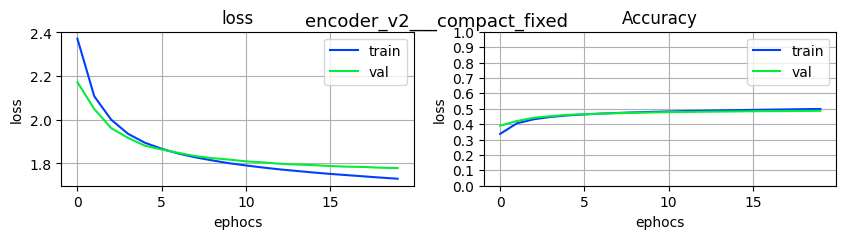

In [61]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))


    plt.subplot(1, 2, 1)

    plt.suptitle(f"{model.name}", fontsize=13)


    plt.grid(True)
    plt.title(f"loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.grid(True)
    plt.title(f"Accuracy")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['accuracy'], label='train')
    plt.plot(model.history['val_accuracy'], label='val')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()

    plt.show()

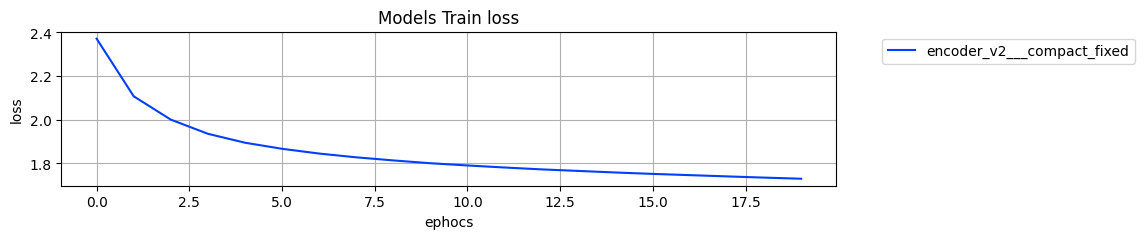

In [62]:
plt.figure(figsize=(10,2))
plt.title(f"Models Train loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)
plt.show()

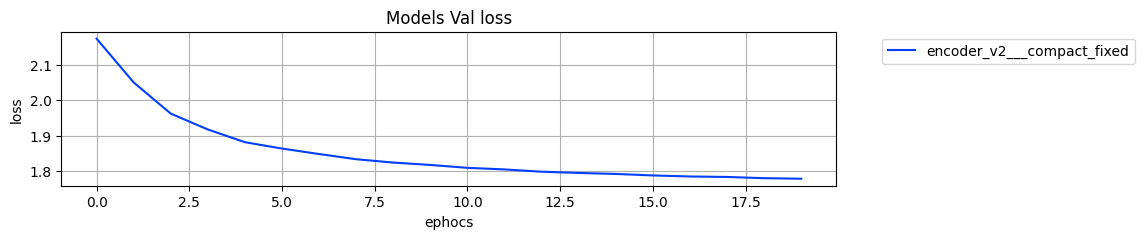

In [63]:
plt.figure(figsize=(10,2))
plt.title(f"Models Val loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['val_loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)

plt.show()

# Inference

In [64]:
best_model_name = "encoder_v2___compact_fixed"
best_model = list(filter(lambda x: x.name == best_model_name, models_list))[0]
print(best_model)

In [65]:
def predict_txt(input_prompt, best_model, iterations, sample_p = True):
    padded_prompt = clean_poem_text(input_prompt)

    yield padded_prompt

    while(len(padded_prompt) < WINDOW_SIZE):
        padded_prompt = START_TOKEN + padded_prompt
        
    while(len(padded_prompt) > WINDOW_SIZE):
        padded_prompt = padded_prompt[1:]

    for i in range(iterations):
        padded_prompt_tokenized = [tokenizer_dict[ch] for ch in padded_prompt]

        padded_prompt_tokenized = np.array([padded_prompt_tokenized])
        pro_output =  best_model.predict(padded_prompt_tokenized, verbose = 0)[0]

        if sample_p:
            ch_num = np.random.choice(len(pro_output), p=pro_output)
        else:
            ch_num = np.argmax(pro_output)
        ch = tokenizer_decode([ch_num])[0]

        padded_prompt = padded_prompt[1:] + ch

        yield ch

        
    return ch

In [66]:
for r in predict_txt("Ÿäÿß ÿπÿ®Ÿäÿ±", best_model.model, 500, False):
    print(r,end='')

Ÿäÿß ÿπÿ®Ÿäÿ± ÿßŸÑŸÖŸàÿ™ ÿßŸÑÿ∞Ÿä ÿßŸÜÿ™ ÿßŸÑŸÖŸÜŸä
ŸàÿßŸÑŸÖÿ±ÿ° ŸÖŸÜ ÿßŸÑÿßŸÖÿ± ÿßŸÑŸÖŸÜŸäÿ±
ŸàÿßŸÑŸÖÿ±ÿ° Ÿäÿπÿ±ŸÅ ŸÖŸÜ ÿßŸÑÿßŸÖÿßŸÑ ŸàÿßŸÑ
ÿßŸÜÿß ÿßŸÑŸÖÿ≥ÿßÿπŸä ÿßŸÑŸÖŸÜŸäÿ± ÿßŸÑŸÖÿ≥Ÿäÿ±
ŸàÿßŸÑŸÖÿßÿ° ÿßŸÑŸÖÿπÿßŸÑŸä ŸàÿßŸÑŸÖÿ±ÿßŸäÿß
ŸàÿßŸÑŸÖŸàÿ™ ÿßŸÑÿß ÿßŸÜ ÿ™ŸÉŸàŸÜ ÿßŸÑŸÖÿ≥Ÿäÿ±
ŸàÿßŸÑŸÖŸàÿ™ ÿßŸÑŸÖŸÜÿßŸäÿß ÿßŸÑŸÖŸÜŸäŸá
ŸàÿßŸÑŸÖŸàÿ™ ÿßŸÑŸÖŸÜÿßŸäÿß ÿßŸÑŸÖÿ≥ÿ™ŸÇŸäŸÖ
ŸàÿßŸÑÿßŸÑ ÿßŸÑŸÖÿ≥ÿßÿπŸä ÿßŸÑŸÖŸÜŸäŸÅ ÿßŸÑŸÖŸÜŸä
ŸàÿßŸÑŸÖÿßÿ° ŸÖŸÜ ÿßŸÑŸÖŸÜÿµÿ® ÿßŸÑŸÖÿπÿØŸàŸÖ
ŸàÿßŸÑÿßŸÑ ŸàÿßŸÑÿßÿ≠ÿ≥ÿßŸÜ ÿßŸÜ ÿßŸÑŸÖŸÜŸä
ŸàÿßŸÑŸÖŸàÿ™ ÿßŸÑŸÖŸÜÿßŸäÿß ŸàÿßŸÑÿ™ŸÇÿØŸäŸÖ
ŸàÿßŸÑÿßŸÑ ÿßŸÑŸÖÿπÿßŸÜŸä ŸàÿßŸÑŸÖŸÜÿßŸäÿß
ŸàÿßŸÑŸÖŸàÿ™ ÿßŸÑŸÖŸÜÿßŸäÿß ŸàÿßŸÑŸÖÿ≥ÿ™ŸÇŸäŸÖ
ŸàÿßŸÑÿßŸÖÿ± ÿßŸÑŸÖÿπÿßŸÑŸä ŸàÿßŸÑŸÖÿπÿßŸÑŸä
ŸàÿßŸÑŸÖŸàÿ™ ÿßŸÑŸÖŸÜÿßŸäÿß ŸàÿßŸÑŸÖÿ≥ÿ™ŸÇŸäŸÖ
ŸàÿßŸÑÿßÿ±ÿ∂ ÿ™ÿ±ÿ¨ÿπ ŸÖŸÜ ÿßŸÑÿßŸÜÿßŸÖ
ŸàÿßŸÑÿßÿ±ÿ∂ ÿßŸÑŸÖŸÜŸäÿ± ŸàÿßŸÑŸÖÿ≥ÿ™ŸÇŸäŸÖ
ŸàÿßŸÑÿßÿ±ÿ∂ ÿ™ÿ±ÿ¨ŸÅ ŸàÿßŸÑÿßÿ≠ÿ≥ÿßŸÖ
ŸàÿßŸÑÿßŸÑ ŸàÿßŸÑÿßÿ≠ÿ≥ÿßŸÜ ÿßŸÑÿß ÿßŸÑŸÖÿπÿßŸÜŸä
ŸàÿßŸÑŸÖŸàÿ™ ÿßŸÑŸÖŸÜÿßŸäÿß Ÿà

# Cache